In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import os
import numpy as np

# Configurazione Percorsi
OUTPUT_DIR = "outputs"
REPORT_PATH = os.path.join(OUTPUT_DIR, "final_report.json")
LOG_PATH = os.path.join(OUTPUT_DIR, "timestamps.log")

# Configurazione Grafica
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerie caricate e percorsi configurati.")

Librerie caricate e percorsi configurati.


In [2]:
def parse_logs(log_path):
    if not os.path.exists(log_path):
        print("File di log non trovato.")
        return pd.DataFrame()

    events = []
    # Regex: Cattura "MESSAGGIO - : DATA ORA..."
    # Esempio: [PROCESSING] PR #1234 - : Mon Jan 12 10:00:00 CET 2025
    regex = re.compile(r"^(.*?) - : (.*)$")
    
    current_pr = None
    pr_start_time = None
    build_start_time = None
    eval_start_time = None
    
    with open(log_path, 'r') as f:
        for line in f:
            match = regex.match(line.strip())
            if not match: continue
            
            msg, ts_str = match.groups()
            # Rimuove timezone (es. CET/CEST) per facilitare il parsing
            ts_clean = re.sub(r'\b[A-Z]{3,5}\b ', '', ts_str).strip()
            try:
                # Adatta il formato se il tuo comando 'date' è diverso
                ts = datetime.strptime(ts_clean, "%a %b %d %H:%M:%S %Y")
            except ValueError:
                continue

            # Inizio PR
            if "[PROCESSING] PR #" in msg:
                current_pr = msg.split("#")[-1].strip()
                pr_start_time = ts
                build_start_time = ts # Assumiamo che il setup inizi subito
                eval_start_time = None
            
            # Fine Setup/Build (Inizio Extraction/Eval)
            elif "[SETUP] Finished setting up Ghidra" in msg and current_pr:
                duration_build = (ts - build_start_time).total_seconds()
                events.append({
                    "PR": current_pr,
                    "Phase": "Build/Setup",
                    "Duration_Sec": duration_build,
                    "Status": "Success",
                    "Timestamp": ts
                })
                eval_start_time = ts # Inizia la fase successiva
            
            # Fallimento Build (Gradlew)
            elif "gradlew not found" in msg or "Command failed" in msg:
                if current_pr:
                    events.append({
                        "PR": current_pr,
                        "Phase": "Build/Setup",
                        "Duration_Sec": (ts - build_start_time).total_seconds() if build_start_time else 0,
                        "Status": "Failed (No Gradlew/Build Error)",
                        "Timestamp": ts
                    })
                    current_pr = None # Reset
            
            # Fine PR
            elif "[PROCESSING] Finished PR #" in msg and current_pr:
                if eval_start_time:
                    duration_eval = (ts - eval_start_time).total_seconds()
                    events.append({
                        "PR": current_pr,
                        "Phase": "Eval & Extraction",
                        "Duration_Sec": duration_eval,
                        "Status": "Success",
                        "Timestamp": ts
                    })
                current_pr = None

    return pd.DataFrame(events)

df_logs = parse_logs(LOG_PATH)

print(f"Log analizzati: {len(df_logs)} eventi trovati.")
if not df_logs.empty:
    display(df_logs.head())
    
    # Report Fallimenti
    failures = df_logs[df_logs["Status"].str.contains("Failed")]
    if not failures.empty:
        print("\n⚠️ PR Fallite prima della build:")
        display(failures[["PR", "Status", "Timestamp"]])
    else:
        print("\n✅ Nessuna PR fallita durante la build.")

Log analizzati: 0 eventi trovati.


In [3]:
def parse_json_report(report_path):
    if not os.path.exists(report_path):
        return pd.DataFrame()
        
    with open(report_path, 'r') as f:
        data = json.load(f)
        
    rows = []
    for entry in data:
        pr = entry.get('pr_number')
        results = entry.get('results', {})
        
        for model, evaluations in results.items():
            for eval_item in evaluations:
                metrics = eval_item.get('metrics', {})
                llm_analysis = eval_item.get('llm_analysis', {})
                
                # Parsing del "Winner" (Pulizia stringa)
                raw_winner = llm_analysis.get('winner', 'Unknown')
                winner = "Tie"
                if "PR" in raw_winner or "B" in raw_winner: winner = "PR"
                elif "Base" in raw_winner or "A" in raw_winner: winner = "Base"
                
                rows.append({
                    "PR": pr,
                    "Model": model,
                    "Function": eval_item.get('function'),
                    "Base_PPL": metrics.get('base_ppl'),
                    "PR_PPL": metrics.get('pr_ppl'),
                    "Delta_PPL": metrics.get('delta_ppl'),
                    "Winner_Choice": winner,
                    "Motivation": llm_analysis.get('motivation', '')
                })
    
    return pd.DataFrame(rows)

df_results = parse_json_report(REPORT_PATH)
print(f"Dati caricati: {len(df_results)} valutazioni totali.")
display(df_results.head())

Dati caricati: 168 valutazioni totali.


,PR,Model,Function,Base_PPL,PR_PPL,Delta_PPL,Winner_Choice,Motivation
0,8834,qwen2.5-1.5b,_init,8.404944,8.404944,0.0,Tie,"system\nYou are Qwen, created by Alibaba Cloud..."
1,8834,qwen2.5-1.5b,FUN_00101020,15.647682,15.647682,0.0,Tie,"system\nYou are Qwen, created by Alibaba Cloud..."
2,8834,qwen2.5-1.5b,__cxa_finalize,39.838642,39.838642,0.0,Tie,"system\nYou are Qwen, created by Alibaba Cloud..."
3,8834,qwen2.5-1.5b,__stack_chk_fail,38.385555,38.385555,0.0,Tie,"system\nYou are Qwen, created by Alibaba Cloud..."
4,8834,qwen2.5-1.5b,__printf_chk,73.711052,73.711052,0.0,Tie,"system\nYou are Qwen, created by Alibaba Cloud..."


In [4]:
if not df_logs.empty:
    # Grafico Tempi per PR suddivisi per Fase
    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_logs, x="PR", y="Duration_Sec", hue="Phase", palette="viridis")
    plt.title("Tempo impiegato per PR: Build vs Eval")
    plt.ylabel("Secondi")
    plt.xticks(rotation=45)
    plt.show()

    # Statistiche veloci
    fastest_build = df_logs[df_logs["Phase"]=="Build/Setup"].sort_values("Duration_Sec").iloc[0]
    print(f"🚀 Build più veloce: PR #{fastest_build['PR']} ({fastest_build['Duration_Sec']:.1f}s)")
    
    slowest_eval = df_logs[df_logs["Phase"]=="Eval & Extraction"].sort_values("Duration_Sec", ascending=False).iloc[0]
    print(f"🐢 Eval più lenta: PR #{slowest_eval['PR']} ({slowest_eval['Duration_Sec']:.1f}s)")

/tmp/ipykernel_241798/1415380943.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x="Model", y="Delta_PPL", palette="coolwarm")


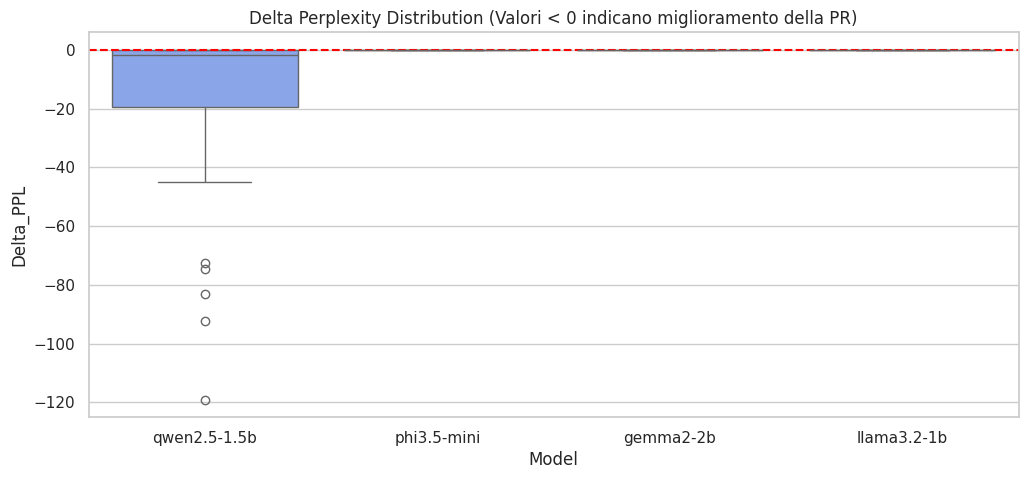

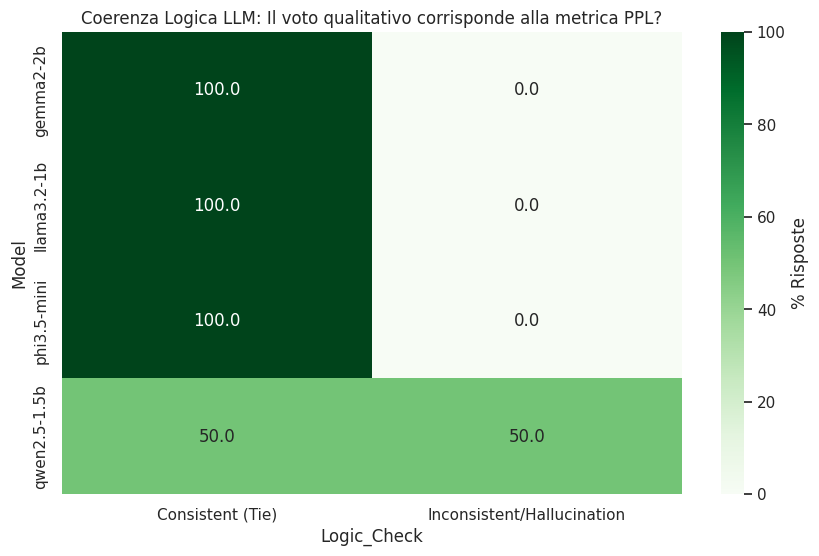

In [5]:
# 1. Delta Perplexity Medio per Modello
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_results, x="Model", y="Delta_PPL", palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.title("Delta Perplexity Distribution (Valori < 0 indicano miglioramento della PR)")
plt.show()

# 2. Analisi di Coerenza (Logic Check)
# Un LLM è "Coerente" se vota PR quando la PPL scende, o Base quando la PPL sale.
def check_consistency(row):
    # Soglia di tolleranza per il Tie (es. differenza PPL < 0.05)
    tolerance = 0.05
    
    if abs(row['Delta_PPL']) < tolerance and row['Winner_Choice'] == 'Tie':
        return "Consistent (Tie)"
    if row['Delta_PPL'] < -tolerance and row['Winner_Choice'] == 'PR':
        return "Consistent (PR Better)"
    if row['Delta_PPL'] > tolerance and row['Winner_Choice'] == 'Base':
        return "Consistent (Base Better)"
    
    return "Inconsistent/Hallucination"

df_results['Logic_Check'] = df_results.apply(check_consistency, axis=1)

# Heatmap della coerenza per Modello
consistency_counts = df_results.groupby(['Model', 'Logic_Check']).size().unstack(fill_value=0)
# Convertiamo in percentuali
consistency_pct = consistency_counts.div(consistency_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(consistency_pct, annot=True, fmt=".1f", cmap="Greens", cbar_kws={'label': '% Risposte'})
plt.title("Coerenza Logica LLM: Il voto qualitativo corrisponde alla metrica PPL?")
plt.show()

Esempio di disaccordo/accordo sulle funzioni:


Model                            gemma2-2b llama3.2-1b phi3.5-mini  \
PR   Function                                                        
8827 FUN_00101020                      Tie         Tie         Tie   
     _ITM_deregisterTMCloneTable       Tie         Tie         Tie   
     _ITM_registerTMCloneTable         Tie         Tie         Tie   
     __cxa_finalize                    Tie         Tie         Tie   
     __do_global_dtors_aux             Tie         Tie         Tie   
     __gmon_start__                    Tie         Tie         Tie   
     __isoc99_scanf                    Tie         Tie         Tie   
     __libc_start_main                 Tie         Tie         Tie   
     __printf_chk                      Tie         Tie         Tie   
     __stack_chk_fail                  Tie         Tie         Tie   

Model                            qwen2.5-1.5b  Agreement_Score  
PR   Function                                                   
8827 FUN_00101020                         Tie              1.0  
     _ITM_deregisterTMCloneTable          Tie              1.0  
     _ITM_registerTMCloneTable            Tie              1.0  
     __cxa_finalize                       Tie              1.0  
     __do_global_dtors_aux                Tie              1.0  
     __gmon_start__                       Tie              1.0  
     __isoc99_scanf                       Tie              1.0  
     __libc_start_main                    Tie              1.0  
     __printf_chk                         Tie              1.0  
     __stack_chk_fail                     Tie              1.0

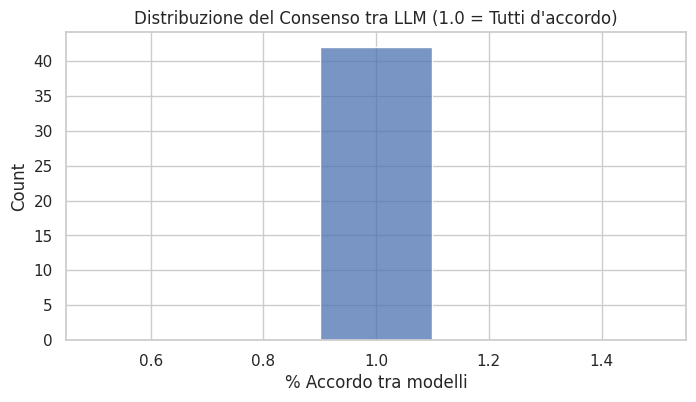

In [6]:
# Creiamo una tabella pivot: Funzione sulle righe, Modelli sulle colonne, Valore = Winner
pivot_agreement = df_results.pivot_table(
    index=['PR', 'Function'], 
    columns='Model', 
    values='Winner_Choice', 
    aggfunc='first' # Prendi il primo valore se ci sono duplicati
)

# Calcolo accordo semplice (su 4 modelli, quanti dicono la stessa cosa?)
def calculate_agreement(row):
    counts = row.value_counts()
    if counts.empty: return 0
    return counts.max() / counts.sum() # Percentuale di accordo della maggioranza

pivot_agreement['Agreement_Score'] = pivot_agreement.apply(calculate_agreement, axis=1)

print("Esempio di disaccordo/accordo sulle funzioni:")
display(pivot_agreement.head(10))

plt.figure(figsize=(8, 4))
sns.histplot(pivot_agreement['Agreement_Score'], bins=5, kde=False)
plt.title("Distribuzione del Consenso tra LLM (1.0 = Tutti d'accordo)")
plt.xlabel("% Accordo tra modelli")
plt.show()